Tutorial:
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb?pli=1#scrollTo=XqS0rFCrqM1o
https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb

To run this excample, you need to install tflite_model_maker


Load dependency

In [1]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from object_detection.utils import label_map_util

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.DEBUG)

2023-11-27 09:38:01.667557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-27 09:38:01.667639: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/developer/Documents/git/Tensorflow/tflite_py/lib64/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/developer/Documents/git/Tensorflow/tflite_py/lib

## Train the object detection model

### Step 1: Load the dataset

* Images in 'train_data' is used to train the custom object detection model.
* Images in 'val_data' is used to check if the model can generalize well to new images that it hasn't seen before

We use the same dataset that is used by the OD API for creating tf record files.



In [2]:
_ODT_LABEL_MAP_PATH = '/home/developer/Documents/git/Tensorflow/workspace/datasets/dataset/MED3-REV1.00/MED3-REV1.00-detect_label_map.pptxt'
_tflite_label_map_saved_path = '/home/developer/Documents/git/Tensorflow/workspace/exported_model/tflite_label_map.txt'
_train_image_dir = '/home/developer/Documents/git/Tensorflow/workspace/datasets/dataset/MED3-REV1.00/MED3-REV1.00-detect/train'
_test_image_dir = '/home/developer/Documents/git/Tensorflow/workspace/datasets/dataset/MED3-REV1.00/MED3-REV1.00-detect/test'

category_index = label_map_util.create_category_index_from_labelmap(_ODT_LABEL_MAP_PATH)
f = open(_tflite_label_map_saved_path, 'w')

#Range are all  label ids in label map
for class_id in range(1, 32+1):
  if class_id not in category_index:
    f.write('???\n')
    continue
  
  name = category_index[class_id]['name']
  f.write(name+'\n')
  
f.close()

def get_labels(label_map_path: str):
    "returns a dict with lables and ids from a tflite_label"
    with open(label_map_path, 'r') as file:
        lines = file.readlines()
    
    label_dict = {}
    for index, line in enumerate(lines):
        line = line.strip()
        label_dict[index+1] = line
    
    return label_dict

train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir=_train_image_dir,
    annotations_dir=_train_image_dir,
    label_map=get_labels(_tflite_label_map_saved_path)
)

test_data = object_detector.DataLoader.from_pascal_voc(
    images_dir=_test_image_dir,
    annotations_dir=_test_image_dir,
    label_map=get_labels(_tflite_label_map_saved_path)
    )


### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here are the available Models that can be used on a custom dataset.

| Model architecture | Input Size | model_spec.get("X") |
|--------------------|-----------|----------------------|
| EfficientDet-Lite0 | 320x320x3 |efficientdet_lite0    |
| EfficientDet-Lite1 | 384x384x3 |efficientdet_lite1    |
| EfficientDet-Lite2 | 448x448x3 |efficientdet_lite2    |
| EfficientDet-Lite3 | 512x512x3 |efficientdet_lite3    |
| EfficientDet-Lite4 | 640x640x3 |efficientdet_lite4    |

<i> The Model Maker Trains a Model and converts Weights into INT8 and Activations into INT16 types (PTQ)
 * EfficientDet-Lite0 is the fastest model with the worst accuracy
 * EfficientDet-Lite4 is the slowest model with the best accuracy
</i>

In this notebook, we use EfficientDet-Lite4 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [3]:
spec = model_spec.get('efficientdet_lite4')

2023-11-27 09:39:11.543543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/developer/Documents/git/Tensorflow/tflite_py/lib/python3.9/site-packages/cv2/../../lib64:
2023-11-27 09:39:11.543651: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-27 09:39:11.543706: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fs-development-machine): /proc/driver/nvidia/version does not exist
2023-11-27 09:39:11.614922: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 40`, which means it will go through the training dataset 40 times.
* Set `batch_size = 10` here so you will see that it takes 41 steps to go through the 410 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [4]:
model = object_detector.create(train_data, model_spec=spec, batch_size=10, train_whole_model=True, epochs=80, validation_data=test_data)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/efficientdet/lite4/feature-vector/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/efficientdet/lite4/feature-vector/2, Total size: 81.21MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/efficientdet/lite4/feature-vector/2'.
INFO:absl:target_size = (640, 640), output_size = (640, 640)
INFO:absl:LR schedule method: cosine
INFO:absl:Use SGD optimizer


Epoch 1/80


2023-11-27 09:39:42.873114: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - ETA: 0s - det_loss: 1.7501 - cls_loss: 1.2171 - box_loss: 0.0107 - reg_l2_loss: 0.1132 - loss: 1.8633 - learning_rate: 0.0102 - gradient_norm: 0.6054 

2023-11-27 10:03:13.907153: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1484s 34s/step - det_loss: 1.7468 - cls_loss: 1.2168 - box_loss: 0.0106 - reg_l2_loss: 0.1132 - loss: 1.8599 - learning_rate: 0.0102 - gradient_norm: 0.6081 - val_det_loss: 1.5485 - val_cls_loss: 1.1714 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.1132 - val_loss: 1.6616
Epoch 2/80
41/41 [==============================] - ETA: 0s - det_loss: 1.4714 - cls_loss: 1.1799 - box_loss: 0.0058 - reg_l2_loss: 0.1132 - loss: 1.5845 - learning_rate: 0.0125 - gradient_norm: 1.1029 

2023-11-27 10:25:17.095846: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1340s 33s/step - det_loss: 1.4692 - cls_loss: 1.1788 - box_loss: 0.0058 - reg_l2_loss: 0.1132 - loss: 1.5824 - learning_rate: 0.0125 - gradient_norm: 1.0987 - val_det_loss: 1.3265 - val_cls_loss: 1.0964 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.1132 - val_loss: 1.4397
Epoch 3/80
41/41 [==============================] - ETA: 0s - det_loss: 1.2110 - cls_loss: 1.0309 - box_loss: 0.0036 - reg_l2_loss: 0.1132 - loss: 1.3241 - learning_rate: 0.0125 - gradient_norm: 1.1969 

2023-11-27 10:47:37.160836: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1340s 33s/step - det_loss: 1.2121 - cls_loss: 1.0315 - box_loss: 0.0036 - reg_l2_loss: 0.1132 - loss: 1.3253 - learning_rate: 0.0125 - gradient_norm: 1.2006 - val_det_loss: 1.0656 - val_cls_loss: 0.8880 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.1132 - val_loss: 1.1788
Epoch 4/80
41/41 [==============================] - ETA: 0s - det_loss: 0.9744 - cls_loss: 0.8346 - box_loss: 0.0028 - reg_l2_loss: 0.1132 - loss: 1.0876 - learning_rate: 0.0124 - gradient_norm: 1.1960 

2023-11-27 11:09:28.692605: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1296s 32s/step - det_loss: 0.9704 - cls_loss: 0.8315 - box_loss: 0.0028 - reg_l2_loss: 0.1132 - loss: 1.0836 - learning_rate: 0.0124 - gradient_norm: 1.1900 - val_det_loss: 0.8427 - val_cls_loss: 0.7094 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.1132 - val_loss: 0.9559
Epoch 5/80
41/41 [==============================] - ETA: 0s - det_loss: 0.8167 - cls_loss: 0.6960 - box_loss: 0.0024 - reg_l2_loss: 0.1132 - loss: 0.9299 - learning_rate: 0.0124 - gradient_norm: 1.1676 

2023-11-27 11:30:23.213783: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 11:31:28.878165: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:use max_reduce for pre-nms topk.


41/41 [==============================] - 1322s 32s/step - det_loss: 0.8137 - cls_loss: 0.6934 - box_loss: 0.0024 - reg_l2_loss: 0.1132 - loss: 0.9269 - learning_rate: 0.0124 - gradient_norm: 1.1654 - val_det_loss: 0.6878 - val_cls_loss: 0.5850 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.1132 - val_loss: 0.8010
Epoch 6/80
41/41 [==============================] - ETA: 0s - det_loss: 0.7064 - cls_loss: 0.5979 - box_loss: 0.0022 - reg_l2_loss: 0.1132 - loss: 0.8196 - learning_rate: 0.0124 - gradient_norm: 1.2229 

2023-11-27 11:52:13.810205: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1234s 30s/step - det_loss: 0.7045 - cls_loss: 0.5963 - box_loss: 0.0022 - reg_l2_loss: 0.1132 - loss: 0.8177 - learning_rate: 0.0124 - gradient_norm: 1.2257 - val_det_loss: 0.5869 - val_cls_loss: 0.4878 - val_box_loss: 0.0020 - val_reg_l2_loss: 0.1132 - val_loss: 0.7001
Epoch 7/80
41/41 [==============================] - ETA: 0s - det_loss: 0.6122 - cls_loss: 0.5068 - box_loss: 0.0021 - reg_l2_loss: 0.1132 - loss: 0.7254 - learning_rate: 0.0123 - gradient_norm: 1.3535 

2023-11-27 12:12:50.878219: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1257s 31s/step - det_loss: 0.6103 - cls_loss: 0.5056 - box_loss: 0.0021 - reg_l2_loss: 0.1132 - loss: 0.7235 - learning_rate: 0.0123 - gradient_norm: 1.3466 - val_det_loss: 0.4908 - val_cls_loss: 0.3981 - val_box_loss: 0.0019 - val_reg_l2_loss: 0.1132 - val_loss: 0.6040
Epoch 8/80
41/41 [==============================] - ETA: 0s - det_loss: 0.5137 - cls_loss: 0.4190 - box_loss: 0.0019 - reg_l2_loss: 0.1132 - loss: 0.6269 - learning_rate: 0.0122 - gradient_norm: 1.3018 

2023-11-27 12:33:41.484665: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1233s 30s/step - det_loss: 0.5134 - cls_loss: 0.4186 - box_loss: 0.0019 - reg_l2_loss: 0.1132 - loss: 0.6266 - learning_rate: 0.0122 - gradient_norm: 1.3019 - val_det_loss: 0.4187 - val_cls_loss: 0.3336 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.1132 - val_loss: 0.5319
Epoch 9/80
41/41 [==============================] - ETA: 0s - det_loss: 0.4476 - cls_loss: 0.3579 - box_loss: 0.0018 - reg_l2_loss: 0.1132 - loss: 0.5608 - learning_rate: 0.0121 - gradient_norm: 1.4209 

2023-11-27 12:53:50.692869: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1209s 30s/step - det_loss: 0.4461 - cls_loss: 0.3569 - box_loss: 0.0018 - reg_l2_loss: 0.1132 - loss: 0.5593 - learning_rate: 0.0121 - gradient_norm: 1.4182 - val_det_loss: 0.4025 - val_cls_loss: 0.3113 - val_box_loss: 0.0018 - val_reg_l2_loss: 0.1132 - val_loss: 0.5157
Epoch 10/80
41/41 [==============================] - ETA: 0s - det_loss: 0.4089 - cls_loss: 0.3201 - box_loss: 0.0018 - reg_l2_loss: 0.1132 - loss: 0.5221 - learning_rate: 0.0121 - gradient_norm: 1.3759 

2023-11-27 13:13:57.209348: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 13:15:08.174505: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1267s 31s/step - det_loss: 0.4088 - cls_loss: 0.3201 - box_loss: 0.0018 - reg_l2_loss: 0.1132 - loss: 0.5220 - learning_rate: 0.0121 - gradient_norm: 1.3737 - val_det_loss: 0.3814 - val_cls_loss: 0.2970 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.1132 - val_loss: 0.4946
Epoch 11/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3763 - cls_loss: 0.2919 - box_loss: 0.0017 - reg_l2_loss: 0.1132 - loss: 0.4895 - learning_rate: 0.0120 - gradient_norm: 1.3319 

2023-11-27 13:34:50.735954: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1197s 29s/step - det_loss: 0.3759 - cls_loss: 0.2913 - box_loss: 0.0017 - reg_l2_loss: 0.1132 - loss: 0.4891 - learning_rate: 0.0120 - gradient_norm: 1.3430 - val_det_loss: 0.3484 - val_cls_loss: 0.2554 - val_box_loss: 0.0019 - val_reg_l2_loss: 0.1132 - val_loss: 0.4616
Epoch 12/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3567 - cls_loss: 0.2737 - box_loss: 0.0017 - reg_l2_loss: 0.1132 - loss: 0.4699 - learning_rate: 0.0119 - gradient_norm: 1.3675 

2023-11-27 13:55:10.468872: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1219s 30s/step - det_loss: 0.3546 - cls_loss: 0.2722 - box_loss: 0.0016 - reg_l2_loss: 0.1132 - loss: 0.4678 - learning_rate: 0.0119 - gradient_norm: 1.3612 - val_det_loss: 0.3057 - val_cls_loss: 0.2302 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.1132 - val_loss: 0.4189
Epoch 13/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3344 - cls_loss: 0.2551 - box_loss: 0.0016 - reg_l2_loss: 0.1132 - loss: 0.4476 - learning_rate: 0.0117 - gradient_norm: 1.3408 

2023-11-27 14:15:24.348693: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1218s 30s/step - det_loss: 0.3354 - cls_loss: 0.2557 - box_loss: 0.0016 - reg_l2_loss: 0.1132 - loss: 0.4486 - learning_rate: 0.0117 - gradient_norm: 1.3491 - val_det_loss: 0.2938 - val_cls_loss: 0.2213 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.1132 - val_loss: 0.4070
Epoch 14/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3136 - cls_loss: 0.2373 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4268 - learning_rate: 0.0116 - gradient_norm: 1.2411 

2023-11-27 14:37:18.380338: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1314s 32s/step - det_loss: 0.3136 - cls_loss: 0.2374 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4267 - learning_rate: 0.0116 - gradient_norm: 1.2406 - val_det_loss: 0.2803 - val_cls_loss: 0.2090 - val_box_loss: 0.0014 - val_reg_l2_loss: 0.1132 - val_loss: 0.3935
Epoch 15/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3060 - cls_loss: 0.2287 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4192 - learning_rate: 0.0115 - gradient_norm: 1.2961 

2023-11-27 14:58:04.029407: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 14:59:16.068706: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1304s 32s/step - det_loss: 0.3057 - cls_loss: 0.2286 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4189 - learning_rate: 0.0115 - gradient_norm: 1.2951 - val_det_loss: 0.2610 - val_cls_loss: 0.1954 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1132 - val_loss: 0.3742
Epoch 16/80
41/41 [==============================] - ETA: 0s - det_loss: 0.3007 - cls_loss: 0.2266 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4139 - learning_rate: 0.0114 - gradient_norm: 1.3974 

2023-11-27 15:20:32.711100: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1294s 32s/step - det_loss: 0.3010 - cls_loss: 0.2271 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4142 - learning_rate: 0.0113 - gradient_norm: 1.3942 - val_det_loss: 0.2604 - val_cls_loss: 0.1869 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.1132 - val_loss: 0.3736
Epoch 17/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2903 - cls_loss: 0.2128 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4035 - learning_rate: 0.0112 - gradient_norm: 1.3007 

2023-11-27 15:42:29.698540: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1322s 32s/step - det_loss: 0.2892 - cls_loss: 0.2118 - box_loss: 0.0015 - reg_l2_loss: 0.1132 - loss: 0.4024 - learning_rate: 0.0112 - gradient_norm: 1.3030 - val_det_loss: 0.2672 - val_cls_loss: 0.1909 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.1132 - val_loss: 0.3804
Epoch 18/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2754 - cls_loss: 0.2053 - box_loss: 0.0014 - reg_l2_loss: 0.1132 - loss: 0.3886 - learning_rate: 0.0110 - gradient_norm: 1.2043 

2023-11-27 16:04:36.024266: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1311s 32s/step - det_loss: 0.2751 - cls_loss: 0.2052 - box_loss: 0.0014 - reg_l2_loss: 0.1132 - loss: 0.3882 - learning_rate: 0.0110 - gradient_norm: 1.2026 - val_det_loss: 0.2456 - val_cls_loss: 0.1792 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1131 - val_loss: 0.3588
Epoch 19/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2697 - cls_loss: 0.1993 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3828 - learning_rate: 0.0109 - gradient_norm: 1.1911 

2023-11-27 16:25:40.058881: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1271s 31s/step - det_loss: 0.2697 - cls_loss: 0.1992 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3828 - learning_rate: 0.0109 - gradient_norm: 1.1854 - val_det_loss: 0.2428 - val_cls_loss: 0.1777 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1131 - val_loss: 0.3559
Epoch 20/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2743 - cls_loss: 0.2023 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3874 - learning_rate: 0.0107 - gradient_norm: 1.3258 

2023-11-27 16:46:44.604441: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 16:48:02.660984: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1331s 33s/step - det_loss: 0.2744 - cls_loss: 0.2026 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3876 - learning_rate: 0.0107 - gradient_norm: 1.3288 - val_det_loss: 0.2357 - val_cls_loss: 0.1721 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1131 - val_loss: 0.3488
Epoch 21/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2544 - cls_loss: 0.1882 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3675 - learning_rate: 0.0105 - gradient_norm: 1.1701 

2023-11-27 17:09:41.474574: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1308s 32s/step - det_loss: 0.2545 - cls_loss: 0.1882 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3676 - learning_rate: 0.0105 - gradient_norm: 1.1695 - val_det_loss: 0.2319 - val_cls_loss: 0.1699 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1131 - val_loss: 0.3450
Epoch 22/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2556 - cls_loss: 0.1887 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3687 - learning_rate: 0.0104 - gradient_norm: 1.2362 

2023-11-27 17:31:20.276945: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1298s 32s/step - det_loss: 0.2547 - cls_loss: 0.1880 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3678 - learning_rate: 0.0104 - gradient_norm: 1.2271 - val_det_loss: 0.2334 - val_cls_loss: 0.1670 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1131 - val_loss: 0.3465
Epoch 23/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2463 - cls_loss: 0.1808 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3594 - learning_rate: 0.0102 - gradient_norm: 1.1607 

2023-11-27 17:52:47.707255: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1289s 32s/step - det_loss: 0.2461 - cls_loss: 0.1806 - box_loss: 0.0013 - reg_l2_loss: 0.1131 - loss: 0.3592 - learning_rate: 0.0102 - gradient_norm: 1.1623 - val_det_loss: 0.2315 - val_cls_loss: 0.1638 - val_box_loss: 0.0014 - val_reg_l2_loss: 0.1131 - val_loss: 0.3446
Epoch 24/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2609 - cls_loss: 0.1908 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3739 - learning_rate: 0.0100 - gradient_norm: 1.3135 

2023-11-27 18:13:31.452882: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1235s 30s/step - det_loss: 0.2613 - cls_loss: 0.1911 - box_loss: 0.0014 - reg_l2_loss: 0.1131 - loss: 0.3744 - learning_rate: 0.0100 - gradient_norm: 1.3102 - val_det_loss: 0.2228 - val_cls_loss: 0.1621 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1131 - val_loss: 0.3359
Epoch 25/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2471 - cls_loss: 0.1781 - box_loss: 0.0014 - reg_l2_loss: 0.1130 - loss: 0.3601 - learning_rate: 0.0098 - gradient_norm: 1.2127 

2023-11-27 18:33:53.643388: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 18:35:03.680145: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1287s 32s/step - det_loss: 0.2492 - cls_loss: 0.1798 - box_loss: 0.0014 - reg_l2_loss: 0.1130 - loss: 0.3622 - learning_rate: 0.0098 - gradient_norm: 1.2252 - val_det_loss: 0.2119 - val_cls_loss: 0.1553 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1130 - val_loss: 0.3249
Epoch 26/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2360 - cls_loss: 0.1730 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3490 - learning_rate: 0.0096 - gradient_norm: 1.1729 

2023-11-27 18:55:02.665634: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1207s 29s/step - det_loss: 0.2358 - cls_loss: 0.1728 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3488 - learning_rate: 0.0096 - gradient_norm: 1.1763 - val_det_loss: 0.2183 - val_cls_loss: 0.1580 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1130 - val_loss: 0.3313
Epoch 27/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2384 - cls_loss: 0.1735 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3515 - learning_rate: 0.0093 - gradient_norm: 1.2069 

2023-11-27 19:15:41.425827: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1247s 30s/step - det_loss: 0.2390 - cls_loss: 0.1738 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3520 - learning_rate: 0.0093 - gradient_norm: 1.2114 - val_det_loss: 0.2123 - val_cls_loss: 0.1502 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1130 - val_loss: 0.3253
Epoch 28/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2418 - cls_loss: 0.1766 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3548 - learning_rate: 0.0091 - gradient_norm: 1.2679 

2023-11-27 19:36:18.562251: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1236s 30s/step - det_loss: 0.2411 - cls_loss: 0.1761 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3541 - learning_rate: 0.0091 - gradient_norm: 1.2599 - val_det_loss: 0.2147 - val_cls_loss: 0.1553 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1130 - val_loss: 0.3276
Epoch 29/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2341 - cls_loss: 0.1686 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3471 - learning_rate: 0.0089 - gradient_norm: 1.2056 

2023-11-27 19:56:52.409982: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1227s 30s/step - det_loss: 0.2338 - cls_loss: 0.1684 - box_loss: 0.0013 - reg_l2_loss: 0.1130 - loss: 0.3467 - learning_rate: 0.0089 - gradient_norm: 1.2078 - val_det_loss: 0.2033 - val_cls_loss: 0.1485 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1130 - val_loss: 0.3162
Epoch 30/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2242 - cls_loss: 0.1624 - box_loss: 0.0012 - reg_l2_loss: 0.1130 - loss: 0.3372 - learning_rate: 0.0087 - gradient_norm: 1.1667 

2023-11-27 20:17:21.905408: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 20:18:32.360095: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1290s 32s/step - det_loss: 0.2249 - cls_loss: 0.1629 - box_loss: 0.0012 - reg_l2_loss: 0.1130 - loss: 0.3378 - learning_rate: 0.0087 - gradient_norm: 1.1702 - val_det_loss: 0.2143 - val_cls_loss: 0.1490 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.1129 - val_loss: 0.3272
Epoch 31/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2305 - cls_loss: 0.1681 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3434 - learning_rate: 0.0084 - gradient_norm: 1.2470 

2023-11-27 20:38:59.132942: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1240s 30s/step - det_loss: 0.2300 - cls_loss: 0.1681 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3429 - learning_rate: 0.0084 - gradient_norm: 1.2588 - val_det_loss: 0.1971 - val_cls_loss: 0.1452 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1129 - val_loss: 0.3101
Epoch 32/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2265 - cls_loss: 0.1658 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3394 - learning_rate: 0.0082 - gradient_norm: 1.1383 

2023-11-27 21:00:42.016410: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1304s 32s/step - det_loss: 0.2268 - cls_loss: 0.1662 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3397 - learning_rate: 0.0082 - gradient_norm: 1.1455 - val_det_loss: 0.1993 - val_cls_loss: 0.1453 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1129 - val_loss: 0.3122
Epoch 33/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2212 - cls_loss: 0.1609 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3341 - learning_rate: 0.0080 - gradient_norm: 1.1390 

2023-11-27 21:21:27.521796: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1244s 30s/step - det_loss: 0.2207 - cls_loss: 0.1607 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3336 - learning_rate: 0.0080 - gradient_norm: 1.1366 - val_det_loss: 0.2014 - val_cls_loss: 0.1470 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1129 - val_loss: 0.3143
Epoch 34/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2202 - cls_loss: 0.1604 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3331 - learning_rate: 0.0077 - gradient_norm: 1.1147 

2023-11-27 21:42:00.484759: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1235s 30s/step - det_loss: 0.2205 - cls_loss: 0.1603 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3334 - learning_rate: 0.0077 - gradient_norm: 1.1154 - val_det_loss: 0.1955 - val_cls_loss: 0.1432 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1129 - val_loss: 0.3084
Epoch 35/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2163 - cls_loss: 0.1577 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3292 - learning_rate: 0.0075 - gradient_norm: 1.1041 

2023-11-27 22:02:23.170102: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 22:03:33.252666: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1280s 31s/step - det_loss: 0.2157 - cls_loss: 0.1573 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3286 - learning_rate: 0.0075 - gradient_norm: 1.1002 - val_det_loss: 0.1951 - val_cls_loss: 0.1368 - val_box_loss: 0.0012 - val_reg_l2_loss: 0.1129 - val_loss: 0.3080
Epoch 36/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2228 - cls_loss: 0.1613 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3356 - learning_rate: 0.0072 - gradient_norm: 1.1988 

2023-11-27 22:23:46.220589: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1220s 30s/step - det_loss: 0.2227 - cls_loss: 0.1612 - box_loss: 0.0012 - reg_l2_loss: 0.1129 - loss: 0.3355 - learning_rate: 0.0072 - gradient_norm: 1.2019 - val_det_loss: 0.1958 - val_cls_loss: 0.1427 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1129 - val_loss: 0.3086
Epoch 37/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2125 - cls_loss: 0.1538 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3253 - learning_rate: 0.0070 - gradient_norm: 1.0966 

2023-11-27 22:44:09.724640: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1229s 30s/step - det_loss: 0.2128 - cls_loss: 0.1544 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3257 - learning_rate: 0.0070 - gradient_norm: 1.1062 - val_det_loss: 0.2011 - val_cls_loss: 0.1467 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1128 - val_loss: 0.3139
Epoch 38/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2155 - cls_loss: 0.1569 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3283 - learning_rate: 0.0067 - gradient_norm: 1.0806 

2023-11-27 23:04:59.352805: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1243s 30s/step - det_loss: 0.2159 - cls_loss: 0.1571 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3287 - learning_rate: 0.0067 - gradient_norm: 1.0760 - val_det_loss: 0.1934 - val_cls_loss: 0.1392 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.1128 - val_loss: 0.3062
Epoch 39/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2086 - cls_loss: 0.1507 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3214 - learning_rate: 0.0065 - gradient_norm: 1.1260 

2023-11-27 23:25:38.732932: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1258s 31s/step - det_loss: 0.2091 - cls_loss: 0.1508 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3219 - learning_rate: 0.0065 - gradient_norm: 1.1345 - val_det_loss: 0.1889 - val_cls_loss: 0.1404 - val_box_loss: 9.6972e-04 - val_reg_l2_loss: 0.1128 - val_loss: 0.3017
Epoch 40/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2103 - cls_loss: 0.1533 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3231 - learning_rate: 0.0063 - gradient_norm: 1.0654 

2023-11-27 23:46:20.647065: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-27 23:47:45.709343: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1303s 32s/step - det_loss: 0.2107 - cls_loss: 0.1535 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3235 - learning_rate: 0.0063 - gradient_norm: 1.0721 - val_det_loss: 0.1850 - val_cls_loss: 0.1359 - val_box_loss: 9.8168e-04 - val_reg_l2_loss: 0.1128 - val_loss: 0.2978
Epoch 41/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2126 - cls_loss: 0.1533 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3254 - learning_rate: 0.0060 - gradient_norm: 1.1395 

2023-11-28 00:07:58.527988: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1218s 30s/step - det_loss: 0.2119 - cls_loss: 0.1529 - box_loss: 0.0012 - reg_l2_loss: 0.1128 - loss: 0.3246 - learning_rate: 0.0060 - gradient_norm: 1.1377 - val_det_loss: 0.1874 - val_cls_loss: 0.1371 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1128 - val_loss: 0.3002
Epoch 42/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2072 - cls_loss: 0.1500 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3199 - learning_rate: 0.0058 - gradient_norm: 1.0679 

2023-11-28 00:28:19.303815: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1223s 30s/step - det_loss: 0.2078 - cls_loss: 0.1507 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3206 - learning_rate: 0.0058 - gradient_norm: 1.0690 - val_det_loss: 0.1886 - val_cls_loss: 0.1388 - val_box_loss: 9.9537e-04 - val_reg_l2_loss: 0.1128 - val_loss: 0.3014
Epoch 43/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2010 - cls_loss: 0.1459 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3138 - learning_rate: 0.0055 - gradient_norm: 1.0648 

2023-11-28 00:48:33.802242: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1215s 30s/step - det_loss: 0.2009 - cls_loss: 0.1459 - box_loss: 0.0011 - reg_l2_loss: 0.1128 - loss: 0.3136 - learning_rate: 0.0055 - gradient_norm: 1.0630 - val_det_loss: 0.1867 - val_cls_loss: 0.1365 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1127 - val_loss: 0.2994
Epoch 44/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2056 - cls_loss: 0.1496 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3183 - learning_rate: 0.0053 - gradient_norm: 1.1110 

2023-11-28 01:08:54.381616: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1224s 30s/step - det_loss: 0.2059 - cls_loss: 0.1499 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3187 - learning_rate: 0.0053 - gradient_norm: 1.1170 - val_det_loss: 0.1863 - val_cls_loss: 0.1360 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1127 - val_loss: 0.2990
Epoch 45/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2033 - cls_loss: 0.1487 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3161 - learning_rate: 0.0050 - gradient_norm: 1.1184 

2023-11-28 01:28:55.325156: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 01:30:00.617322: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1253s 31s/step - det_loss: 0.2024 - cls_loss: 0.1482 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3151 - learning_rate: 0.0050 - gradient_norm: 1.1103 - val_det_loss: 0.1843 - val_cls_loss: 0.1350 - val_box_loss: 9.8435e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2970
Epoch 46/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1981 - cls_loss: 0.1429 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3108 - learning_rate: 0.0048 - gradient_norm: 1.0697 

2023-11-28 01:49:54.175259: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1208s 30s/step - det_loss: 0.1983 - cls_loss: 0.1430 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3110 - learning_rate: 0.0048 - gradient_norm: 1.0688 - val_det_loss: 0.1826 - val_cls_loss: 0.1344 - val_box_loss: 9.6355e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2953
Epoch 47/80
41/41 [==============================] - ETA: 0s - det_loss: 0.2005 - cls_loss: 0.1456 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3132 - learning_rate: 0.0045 - gradient_norm: 1.0706 

2023-11-28 02:10:21.572447: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1239s 30s/step - det_loss: 0.2010 - cls_loss: 0.1459 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3137 - learning_rate: 0.0045 - gradient_norm: 1.0685 - val_det_loss: 0.1864 - val_cls_loss: 0.1378 - val_box_loss: 9.7252e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2991
Epoch 48/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1982 - cls_loss: 0.1442 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3109 - learning_rate: 0.0043 - gradient_norm: 1.0325 

2023-11-28 02:30:49.862343: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1215s 30s/step - det_loss: 0.1979 - cls_loss: 0.1441 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3106 - learning_rate: 0.0043 - gradient_norm: 1.0285 - val_det_loss: 0.1870 - val_cls_loss: 0.1348 - val_box_loss: 0.0010 - val_reg_l2_loss: 0.1127 - val_loss: 0.2996
Epoch 49/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1962 - cls_loss: 0.1434 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3089 - learning_rate: 0.0041 - gradient_norm: 1.0442 

2023-11-28 02:51:33.851859: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1252s 31s/step - det_loss: 0.1966 - cls_loss: 0.1435 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3092 - learning_rate: 0.0041 - gradient_norm: 1.0447 - val_det_loss: 0.1809 - val_cls_loss: 0.1327 - val_box_loss: 9.6538e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2936
Epoch 50/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1970 - cls_loss: 0.1429 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3096 - learning_rate: 0.0038 - gradient_norm: 1.0558 

2023-11-28 03:12:10.918697: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 03:13:23.533995: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1291s 32s/step - det_loss: 0.1969 - cls_loss: 0.1427 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3096 - learning_rate: 0.0038 - gradient_norm: 1.0523 - val_det_loss: 0.1801 - val_cls_loss: 0.1324 - val_box_loss: 9.5381e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2927
Epoch 51/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1962 - cls_loss: 0.1425 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3088 - learning_rate: 0.0036 - gradient_norm: 1.0724 

2023-11-28 03:34:08.497700: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1251s 31s/step - det_loss: 0.1963 - cls_loss: 0.1427 - box_loss: 0.0011 - reg_l2_loss: 0.1127 - loss: 0.3090 - learning_rate: 0.0036 - gradient_norm: 1.0694 - val_det_loss: 0.1784 - val_cls_loss: 0.1293 - val_box_loss: 9.8289e-04 - val_reg_l2_loss: 0.1127 - val_loss: 0.2911
Epoch 52/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1921 - cls_loss: 0.1411 - box_loss: 0.0010 - reg_l2_loss: 0.1127 - loss: 0.3047 - learning_rate: 0.0034 - gradient_norm: 1.0233    

2023-11-28 03:54:59.464540: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1253s 31s/step - det_loss: 0.1931 - cls_loss: 0.1416 - box_loss: 0.0010 - reg_l2_loss: 0.1127 - loss: 0.3057 - learning_rate: 0.0034 - gradient_norm: 1.0246 - val_det_loss: 0.1763 - val_cls_loss: 0.1298 - val_box_loss: 9.2873e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2889
Epoch 53/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1922 - cls_loss: 0.1412 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3049 - learning_rate: 0.0032 - gradient_norm: 1.0403 

2023-11-28 04:15:42.418549: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1249s 31s/step - det_loss: 0.1921 - cls_loss: 0.1411 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3048 - learning_rate: 0.0032 - gradient_norm: 1.0422 - val_det_loss: 0.1804 - val_cls_loss: 0.1328 - val_box_loss: 9.5302e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2931
Epoch 54/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1905 - cls_loss: 0.1397 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3032 - learning_rate: 0.0030 - gradient_norm: 1.0264 

2023-11-28 04:36:12.634655: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1219s 30s/step - det_loss: 0.1904 - cls_loss: 0.1395 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3030 - learning_rate: 0.0029 - gradient_norm: 1.0289 - val_det_loss: 0.1777 - val_cls_loss: 0.1303 - val_box_loss: 9.4753e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2903
Epoch 55/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1899 - cls_loss: 0.1383 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3025 - learning_rate: 0.0027 - gradient_norm: 0.9912 

2023-11-28 04:56:29.533141: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 04:57:36.464466: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1281s 31s/step - det_loss: 0.1907 - cls_loss: 0.1387 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3033 - learning_rate: 0.0027 - gradient_norm: 1.0027 - val_det_loss: 0.1787 - val_cls_loss: 0.1298 - val_box_loss: 9.7832e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2913
Epoch 56/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1965 - cls_loss: 0.1428 - box_loss: 0.0011 - reg_l2_loss: 0.1126 - loss: 0.3091 - learning_rate: 0.0025 - gradient_norm: 1.0625 

2023-11-28 05:17:47.341146: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1220s 30s/step - det_loss: 0.1978 - cls_loss: 0.1437 - box_loss: 0.0011 - reg_l2_loss: 0.1126 - loss: 0.3105 - learning_rate: 0.0025 - gradient_norm: 1.0782 - val_det_loss: 0.1753 - val_cls_loss: 0.1287 - val_box_loss: 9.3287e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2880
Epoch 57/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1896 - cls_loss: 0.1383 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3022 - learning_rate: 0.0023 - gradient_norm: 0.9890 

2023-11-28 05:37:59.381265: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1212s 30s/step - det_loss: 0.1891 - cls_loss: 0.1380 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3017 - learning_rate: 0.0023 - gradient_norm: 0.9888 - val_det_loss: 0.1734 - val_cls_loss: 0.1272 - val_box_loss: 9.2380e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2860
Epoch 58/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1902 - cls_loss: 0.1396 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3028 - learning_rate: 0.0022 - gradient_norm: 1.0193 

2023-11-28 05:58:28.393877: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1228s 30s/step - det_loss: 0.1899 - cls_loss: 0.1394 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3025 - learning_rate: 0.0021 - gradient_norm: 1.0204 - val_det_loss: 0.1730 - val_cls_loss: 0.1273 - val_box_loss: 9.1352e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2856
Epoch 59/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1925 - cls_loss: 0.1399 - box_loss: 0.0011 - reg_l2_loss: 0.1126 - loss: 0.3051 - learning_rate: 0.0020 - gradient_norm: 1.0409 

2023-11-28 06:18:37.473026: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1213s 30s/step - det_loss: 0.1922 - cls_loss: 0.1397 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3048 - learning_rate: 0.0020 - gradient_norm: 1.0342 - val_det_loss: 0.1729 - val_cls_loss: 0.1266 - val_box_loss: 9.2532e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2855
Epoch 60/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1883 - cls_loss: 0.1374 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3009 - learning_rate: 0.0018 - gradient_norm: 1.0071 

2023-11-28 06:38:41.016221: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 06:39:51.434681: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1262s 31s/step - det_loss: 0.1888 - cls_loss: 0.1377 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3014 - learning_rate: 0.0018 - gradient_norm: 1.0066 - val_det_loss: 0.1713 - val_cls_loss: 0.1259 - val_box_loss: 9.0813e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2839
Epoch 61/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1905 - cls_loss: 0.1381 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3031 - learning_rate: 0.0016 - gradient_norm: 1.0569 

2023-11-28 06:59:45.557199: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1204s 29s/step - det_loss: 0.1904 - cls_loss: 0.1381 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3030 - learning_rate: 0.0016 - gradient_norm: 1.0521 - val_det_loss: 0.1728 - val_cls_loss: 0.1265 - val_box_loss: 9.2463e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2854
Epoch 62/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1903 - cls_loss: 0.1393 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3029 - learning_rate: 0.0015 - gradient_norm: 1.0762 

2023-11-28 07:19:40.080661: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1194s 29s/step - det_loss: 0.1904 - cls_loss: 0.1394 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3030 - learning_rate: 0.0015 - gradient_norm: 1.0763 - val_det_loss: 0.1701 - val_cls_loss: 0.1257 - val_box_loss: 8.8848e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2827
Epoch 63/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1861 - cls_loss: 0.1363 - box_loss: 9.9615e-04 - reg_l2_loss: 0.1126 - loss: 0.2987 - learning_rate: 0.0013 - gradient_norm: 1.0032

2023-11-28 07:39:49.440246: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1207s 29s/step - det_loss: 0.1854 - cls_loss: 0.1359 - box_loss: 9.9062e-04 - reg_l2_loss: 0.1126 - loss: 0.2980 - learning_rate: 0.0013 - gradient_norm: 0.9999 - val_det_loss: 0.1691 - val_cls_loss: 0.1246 - val_box_loss: 8.9091e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2817
Epoch 64/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1884 - cls_loss: 0.1364 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3009 - learning_rate: 0.0012 - gradient_norm: 1.0126 

2023-11-28 07:59:57.568231: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1211s 30s/step - det_loss: 0.1890 - cls_loss: 0.1370 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3016 - learning_rate: 0.0012 - gradient_norm: 1.0303 - val_det_loss: 0.1702 - val_cls_loss: 0.1252 - val_box_loss: 8.9972e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2828
Epoch 65/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1888 - cls_loss: 0.1381 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3014 - learning_rate: 0.0010 - gradient_norm: 0.9609    

2023-11-28 08:20:04.624031: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 08:21:12.864911: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1266s 31s/step - det_loss: 0.1898 - cls_loss: 0.1388 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3024 - learning_rate: 0.0010 - gradient_norm: 0.9663 - val_det_loss: 0.1700 - val_cls_loss: 0.1251 - val_box_loss: 8.9711e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2826
Epoch 66/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1864 - cls_loss: 0.1372 - box_loss: 9.8413e-04 - reg_l2_loss: 0.1126 - loss: 0.2990 - learning_rate: 8.8114e-04 - gradient_norm: 0.9863 

2023-11-28 08:41:16.159347: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1208s 29s/step - det_loss: 0.1870 - cls_loss: 0.1376 - box_loss: 9.8853e-04 - reg_l2_loss: 0.1126 - loss: 0.2996 - learning_rate: 8.7968e-04 - gradient_norm: 0.9883 - val_det_loss: 0.1696 - val_cls_loss: 0.1254 - val_box_loss: 8.8317e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2822
Epoch 67/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1841 - cls_loss: 0.1357 - box_loss: 9.6852e-04 - reg_l2_loss: 0.1126 - loss: 0.2967 - learning_rate: 7.5821e-04 - gradient_norm: 1.0476 

2023-11-28 09:01:21.768927: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1224s 30s/step - det_loss: 0.1848 - cls_loss: 0.1364 - box_loss: 9.6965e-04 - reg_l2_loss: 0.1126 - loss: 0.2974 - learning_rate: 7.5685e-04 - gradient_norm: 1.0574 - val_det_loss: 0.1696 - val_cls_loss: 0.1250 - val_box_loss: 8.9127e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2822
Epoch 68/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1871 - cls_loss: 0.1378 - box_loss: 9.8602e-04 - reg_l2_loss: 0.1126 - loss: 0.2996 - learning_rate: 6.4397e-04 - gradient_norm: 0.9981 

2023-11-28 09:21:56.349538: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1224s 30s/step - det_loss: 0.1877 - cls_loss: 0.1381 - box_loss: 9.9046e-04 - reg_l2_loss: 0.1126 - loss: 0.3002 - learning_rate: 6.4271e-04 - gradient_norm: 1.0060 - val_det_loss: 0.1690 - val_cls_loss: 0.1243 - val_box_loss: 8.9366e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2816
Epoch 69/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1860 - cls_loss: 0.1363 - box_loss: 9.9393e-04 - reg_l2_loss: 0.1126 - loss: 0.2985 - learning_rate: 5.3858e-04 - gradient_norm: 0.9905 

2023-11-28 09:42:43.009754: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1242s 30s/step - det_loss: 0.1855 - cls_loss: 0.1359 - box_loss: 9.9234e-04 - reg_l2_loss: 0.1126 - loss: 0.2981 - learning_rate: 5.3743e-04 - gradient_norm: 0.9854 - val_det_loss: 0.1704 - val_cls_loss: 0.1251 - val_box_loss: 9.0513e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2829
Epoch 70/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1850 - cls_loss: 0.1357 - box_loss: 9.8696e-04 - reg_l2_loss: 0.1126 - loss: 0.2976 - learning_rate: 4.4223e-04 - gradient_norm: 1.0025 

2023-11-28 10:03:32.122789: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 10:04:47.941828: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1320s 32s/step - det_loss: 0.1851 - cls_loss: 0.1358 - box_loss: 9.8673e-04 - reg_l2_loss: 0.1126 - loss: 0.2977 - learning_rate: 4.4118e-04 - gradient_norm: 1.0011 - val_det_loss: 0.1702 - val_cls_loss: 0.1250 - val_box_loss: 9.0215e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2827
Epoch 71/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1796 - cls_loss: 0.1321 - box_loss: 9.4863e-04 - reg_l2_loss: 0.1126 - loss: 0.2921 - learning_rate: 3.5506e-04 - gradient_norm: 0.9355 

2023-11-28 10:26:16.149143: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1307s 32s/step - det_loss: 0.1796 - cls_loss: 0.1322 - box_loss: 9.4971e-04 - reg_l2_loss: 0.1126 - loss: 0.2922 - learning_rate: 3.5412e-04 - gradient_norm: 0.9366 - val_det_loss: 0.1687 - val_cls_loss: 0.1245 - val_box_loss: 8.8519e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2813
Epoch 72/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1885 - cls_loss: 0.1368 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3010 - learning_rate: 2.7721e-04 - gradient_norm: 1.0284 

2023-11-28 10:47:58.495078: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1288s 31s/step - det_loss: 0.1891 - cls_loss: 0.1371 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3017 - learning_rate: 2.7638e-04 - gradient_norm: 1.0332 - val_det_loss: 0.1695 - val_cls_loss: 0.1247 - val_box_loss: 8.9620e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2820
Epoch 73/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1878 - cls_loss: 0.1376 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3004 - learning_rate: 2.0881e-04 - gradient_norm: 1.0390   

2023-11-28 11:09:53.110191: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1321s 32s/step - det_loss: 0.1880 - cls_loss: 0.1376 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3006 - learning_rate: 2.0809e-04 - gradient_norm: 1.0360 - val_det_loss: 0.1695 - val_cls_loss: 0.1243 - val_box_loss: 9.0410e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2821
Epoch 74/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1894 - cls_loss: 0.1371 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3019 - learning_rate: 1.4996e-04 - gradient_norm: 1.0353 

2023-11-28 11:31:34.911771: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1312s 32s/step - det_loss: 0.1889 - cls_loss: 0.1369 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3015 - learning_rate: 1.4935e-04 - gradient_norm: 1.0285 - val_det_loss: 0.1695 - val_cls_loss: 0.1246 - val_box_loss: 8.9923e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2821
Epoch 75/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1833 - cls_loss: 0.1342 - box_loss: 9.8250e-04 - reg_l2_loss: 0.1126 - loss: 0.2959 - learning_rate: 1.0075e-04 - gradient_norm: 0.9724 

2023-11-28 11:53:03.243148: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 11:54:22.017481: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1346s 33s/step - det_loss: 0.1835 - cls_loss: 0.1341 - box_loss: 9.8726e-04 - reg_l2_loss: 0.1126 - loss: 0.2960 - learning_rate: 1.0025e-04 - gradient_norm: 0.9737 - val_det_loss: 0.1691 - val_cls_loss: 0.1247 - val_box_loss: 8.8779e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2817
Epoch 76/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1839 - cls_loss: 0.1346 - box_loss: 9.8724e-04 - reg_l2_loss: 0.1126 - loss: 0.2965 - learning_rate: 6.1270e-05 - gradient_norm: 0.9748 

2023-11-28 12:15:53.146519: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1299s 32s/step - det_loss: 0.1839 - cls_loss: 0.1345 - box_loss: 9.8670e-04 - reg_l2_loss: 0.1126 - loss: 0.2964 - learning_rate: 6.0886e-05 - gradient_norm: 0.9735 - val_det_loss: 0.1692 - val_cls_loss: 0.1246 - val_box_loss: 8.9150e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2818
Epoch 77/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1861 - cls_loss: 0.1364 - box_loss: 9.9401e-04 - reg_l2_loss: 0.1126 - loss: 0.2986 - learning_rate: 3.1573e-05 - gradient_norm: 1.0888 

2023-11-28 12:36:53.319757: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1273s 31s/step - det_loss: 0.1876 - cls_loss: 0.1374 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3001 - learning_rate: 3.1303e-05 - gradient_norm: 1.1037 - val_det_loss: 0.1693 - val_cls_loss: 0.1246 - val_box_loss: 8.9380e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2818
Epoch 78/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1834 - cls_loss: 0.1333 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.2960 - learning_rate: 1.1708e-05 - gradient_norm: 0.9650     

2023-11-28 12:57:59.150492: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1249s 31s/step - det_loss: 0.1845 - cls_loss: 0.1342 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.2971 - learning_rate: 1.1553e-05 - gradient_norm: 0.9967 - val_det_loss: 0.1694 - val_cls_loss: 0.1247 - val_box_loss: 8.9572e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2820
Epoch 79/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1866 - cls_loss: 0.1360 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.2992 - learning_rate: 1.7079e-06 - gradient_norm: 0.9889 

2023-11-28 13:18:31.381489: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1231s 30s/step - det_loss: 0.1870 - cls_loss: 0.1363 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.2996 - learning_rate: 1.6673e-06 - gradient_norm: 0.9877 - val_det_loss: 0.1695 - val_cls_loss: 0.1248 - val_box_loss: 8.9559e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2821
Epoch 80/80
41/41 [==============================] - ETA: 0s - det_loss: 0.1882 - cls_loss: 0.1375 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3008 - learning_rate: 1.5874e-06 - gradient_norm: 1.0060 

2023-11-28 13:38:39.567646: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-11-28 13:39:54.739525: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


41/41 [==============================] - 1278s 31s/step - det_loss: 0.1882 - cls_loss: 0.1375 - box_loss: 0.0010 - reg_l2_loss: 0.1126 - loss: 0.3008 - learning_rate: 1.6616e-06 - gradient_norm: 1.0034 - val_det_loss: 0.1693 - val_cls_loss: 0.1246 - val_box_loss: 8.9403e-04 - val_reg_l2_loss: 0.1126 - val_loss: 0.2819


### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [5]:
model.evaluate(test_data)

2023-11-28 13:40:59.143612: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
INFO:absl:use max_reduce for pre-nms topk.


2/3 [===================>..........] - ETA: 35s 

INFO:absl:use max_reduce for pre-nms topk.


3/3 [==============================] - 144s 23s/step



{'AP': 0.75038075,
 'AP50': 0.99642426,
 'AP75': 0.9034647,
 'APs': 0.68718576,
 'APm': 0.74625057,
 'APl': 0.90686584,
 'ARmax1': 0.7877973,
 'ARmax10': 0.8108391,
 'ARmax100': 0.8108391,
 'ARs': 0.7446809,
 'ARm': 0.7972493,
 'ARl': 0.9344894,
 'AP_/J6_ok': 0.83935916,
 'AP_/J6_missing': 0.7712821,
 'AP_/J12_ok': 0.859749,
 'AP_/J12_missing': 0.7428047,
 'AP_/J14_ok': 0.8011194,
 'AP_/J14_placement': 0.8325317,
 'AP_/J14_missing': 0.72949433,
 'AP_/J10_ok': 0.7343076,
 'AP_/J10_placement': 0.7387236,
 'AP_/J10_missing': 0.64268386,
 'AP_/J09_ok': 0.68190914,
 'AP_/J09_placement': 0.62678367,
 'AP_/J09_missing': 0.63641226,
 'AP_/J11_ok': 0.74197173,
 'AP_/J11_placement': 0.81650096,
 'AP_/J11_missing': 0.64301896,
 'AP_/J13_ok': 0.72400236,
 'AP_/J13_placement': 0.793227,
 'AP_/J13_missing': 0.53944385,
 'AP_/J2_ok': 0.7494362,
 'AP_/J2_placement': 0.7848542,
 'AP_/J2_missing': 0.59041566,
 'AP_/J3_ok': 0.74900097,
 'AP_/J3_placement': 0.72163385,
 'AP_/J3_missing': 0.63645,
 'AP_/C5

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Embedded CPU and also compatible with the TPU/NPU peripherie.

The export formats can be one or a list of the following:

    ExportFormat.TFLITE
    ExportFormat.LABEL
    ExportFormat.SAVED_MODEL



In [13]:
config = QuantizationConfig(
    inference_input_type=tf.float32,
    inference_output_type=tf.float32,
    representative_data=train_data,
    quantization_steps=100,
    supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8,tf.lite.OpsSet.TFLITE_BUILTINS],
    experimental_new_quantizer=True
)

In [14]:
model.export(export_dir='./exported_model', tflite_filename='med3_detect_efficientdet_lite4.tflite', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL,ExportFormat.TFLITE], quantization_config=config)

2023-11-28 15:40:03.484643: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2023-11-28 15:40:19.657613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-11-28 15:40:19.657694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-11-28 15:40:19.658070: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmps43b4dj_
2023-11-28 15:40:19.844034: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-11-28 15:40:19.844100: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmps43b4dj_
2023-11-28 15:40:20.524521: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-11-28 15:40:25.995844: I tensorflow/cc/saved_

## Example of how to run a tflite model

In [15]:
interpreter = tf.lite.Interpreter(model_path='./exported_model/med3_detect_efficientdet_lite4.tflite')
interpreter.allocate_tensors()
spec.config.num_classes

32

In [16]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name


print(classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.float32)
  resized_img = (resized_img -127.5)/127.5
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

['J6_ok', 'J6_missing', 'J12_ok', 'J12_missing', 'J14_ok', 'J14_placement', 'J14_missing', 'J10_ok', 'J10_placement', 'J10_missing', 'J09_ok', 'J09_placement', 'J09_missing', 'J11_ok', 'J11_placement', 'J11_missing', 'J13_ok', 'J13_placement', 'J13_missing', 'J2_ok', 'J2_placement', 'J2_missing', 'J3_ok', 'J3_placement', 'J3_missing', 'C59_ok', 'C59_placement', 'C59_missing', 'J4_ok', 'J4_missing', 'MED3-REV1.00_0deg', 'MED3-REV1.00_180deg']


In [17]:

detection_results_img = run_odt_and_draw_results(image_path='/home/developer/Documents/git/Tensorflow/workspace/datasets/dataset/MED3-REV1.00/MED3-REV1.00-detect/test/MED3-REV1.00_2023-10-16_13-11-40.jpg', interpreter=interpreter, threshold=0.5)

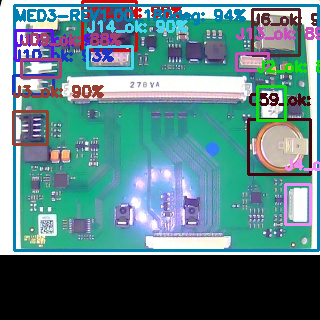

In [18]:
Image.fromarray(detection_results_img)